### Imports

In [1]:
import numpy as np
import torch
import pickle
import gymnasium as gym
import highway_env

### Setting up environement

In [2]:
# Making highway environment
env = gym.make("highway-fast-v0", render_mode="human")

# Importing config
with open('1-highway-discrete-config.pkl', 'rb') as pf:
    config_dict = pickle.load(pf)
env.unwrapped.configure(config_dict)

### Creating DQN Network

In [3]:
import torch.nn as nn

class DQNNet(nn.Sequential):
    def __init__(self, state_dim, d_hid, n_actions):
        super(DQNNet,self).__init__()

        # takes as input the dimension of our state space
        self.fc1 = nn.Linear(state_dim,d_hid)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(d_hid, d_hid)
        self.relu2 = nn.ReLU()
        # Output the expected cumulative return for each action
        self.fc3 = nn.Linear(d_hid, n_actions)

### Creating Replay Buffer

In [4]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, maxsize):
        self.buffer = deque([], maxlen=maxsize)
        self.max_size = maxsize

    def push(self, s, a, r, sn, done):
        self.buffer.append((s,a,r,sn, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, min(len(self.buffer), batch_size))
    
    def get_len(self):
        return len(self.buffer)

### Creating DQN algorithm

In [8]:
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
class DQN:
    def __init__(self,buffer_size):
        self.curr_step = 1
        env = gym.make("highway-fast-v0", render_mode="human")
        test_env = gym.make("highway-fast-v0", render_mode="human")
        # Importing config
        with open('1-highway-discrete-config.pkl', 'rb') as pf:
            config_dict = pickle.load(pf)
        env.unwrapped.configure(config_dict)
        test_env.unwrapped.configure(config_dict)
        self.env = env
        self.test_env = test_env
        obs, info = self.env.reset()
        self.curr_obs = torch.tensor(obs.flatten())
        self.action_space = self.env.action_space
        self.q_net = DQNNet(len(self.curr_obs.flatten()), 256, self.action_space.n)
        self.target_net = DQNNet(len(self.curr_obs.flatten()), 256, self.action_space.n)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.replay_buffer = ReplayBuffer(maxsize = buffer_size)
        self.gamma = 0.8
        self.batchsize = 32
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=0.005)
        self.epsilon = 1
        self.epsilon_decay = 0.9999
        self.loss_list = []

    def sample_action(self, epsilon):

        if random.random() < epsilon:
            return self.action_space.sample()
        else:
            return torch.argmax(self.q_net(self.curr_obs))
    
    def update_buffer(self,s,a,r,sn, done):
        
        def to_tensor(x):
            if isinstance(x, torch.Tensor):
                return x
            
            return torch.tensor(x)
        
        s_torch = to_tensor(s.flatten())
        a_torch = to_tensor(a)
        r_torch = to_tensor(r)
        sn_torch = to_tensor(sn.flatten())
        done_torch = to_tensor(done)
        self.replay_buffer.push(s_torch,a_torch,r_torch,sn_torch,done_torch)
        
    
    def compute_target(self, done, reward, obs):
        return reward.reshape(-1,1) + (1-done.reshape(-1,1)) * self.gamma * torch.max(self.target_net(obs),dim=1).values.reshape(-1,1)

    def sample_minibatch(self, batchsize):      
        batch = self.replay_buffer.sample(batchsize)
        batch_curr_obs, batch_a, batch_r, batch_obs, batch_done = map(list, zip(*batch))

        batch_curr_obs = torch.from_numpy(np.stack(batch_curr_obs)).float()
        batch_a        = torch.tensor(batch_a, dtype=torch.int64)    # or float32 if continuous
        batch_r        = torch.tensor(batch_r, dtype=torch.float32)
        batch_obs      = torch.from_numpy(np.stack(batch_obs)).float()
        batch_done     = torch.tensor(batch_done, dtype=torch.float32)

        return batch_curr_obs, batch_a, batch_r, batch_obs, batch_done
    
    def step(self):
        
        self.q_net.train()
        # Sample an action
        a = self.sample_action(self.epsilon)
        
        # Perform one transition
        obs, reward, terminated, truncated, _ = self.env.step(a)

        done = terminated or truncated

        # Update the replay buffer
        self.update_buffer(self.curr_obs, a, reward, obs, done)
        
        # Sample a minibatch of transitions from the replay buffer
        self.curr_obs = torch.tensor(obs.flatten())
        batch_curr_obs, batch_a, batch_r, batch_obs, batch_done = self.sample_minibatch(self.batchsize)
        
        # Compute the target
        with torch.no_grad():
            ys = self.compute_target(batch_done, batch_r, batch_obs)
        
        # Compute the predictions on the return
        preds = self.q_net(batch_curr_obs).gather(1, batch_a.reshape(-1,1))

        loss = self.criterion(preds, ys)

        self.loss_list.append(loss.item())

        self.optimizer.zero_grad()

        loss.backward()

        self.optimizer.step()

        return done

    def train(self):

        for episode in tqdm(range(1, 10000)):
            done = 0
            self.curr_obs, _ = self.env.reset()
            self.curr_obs = torch.tensor(self.curr_obs.flatten())
            while not done:
                done = self.step()
                self.epsilon = max(0.05, self.epsilon * self.epsilon_decay)
                self.curr_step += 1
                if self.curr_step% 50 == 0:
                    self.target_net.load_state_dict(self.q_net.state_dict())

            if episode % 50 == 0:
                plt.plot(self.loss_list)
                plt.show()
                self.curr_obs, _ = self.test_env.reset()
                self.curr_obs = torch.tensor(self.curr_obs.flatten())
                done = 0
                cum_ret = 0
                it = 0
                with torch.no_grad():
                    self.q_net.eval()
                    
                    while not done:
                
                        a = self.sample_action(epsilon=0)
                        self.curr_obs, reward, terminated, truncated, _ = self.test_env.step(a)
                        done = terminated or truncated
                        self.curr_obs = torch.tensor(self.curr_obs.flatten())
                        cum_ret += self.gamma**it * reward
                        it += 1

                    self.q_net.train()
                print(f'Reward on a test environnement at episode {episode}: {cum_ret}')


In [9]:
dqn = DQN(buffer_size=15000)

  0%|          | 49/9999 [04:50<12:37:47,  4.57s/it]

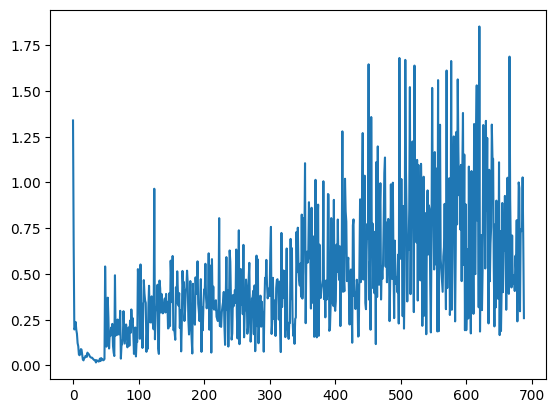

  1%|          | 50/9999 [04:57<14:14:20,  5.15s/it]

Reward on a test environnement at episode 50: 2.8804558123552635


  1%|          | 99/9999 [10:42<20:46:28,  7.55s/it]

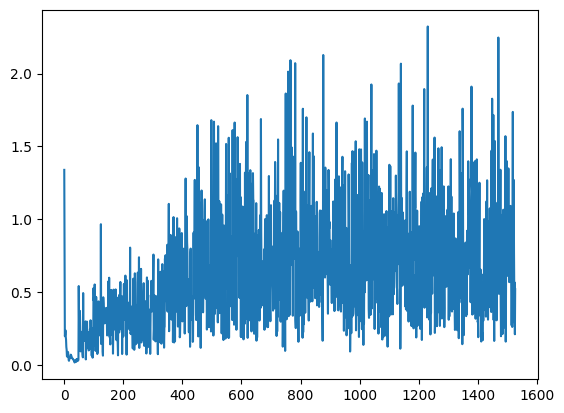

  1%|          | 100/9999 [10:52<22:40:57,  8.25s/it]

Reward on a test environnement at episode 100: 0.9656445312414441


  1%|▏         | 149/9999 [16:06<15:33:14,  5.68s/it]

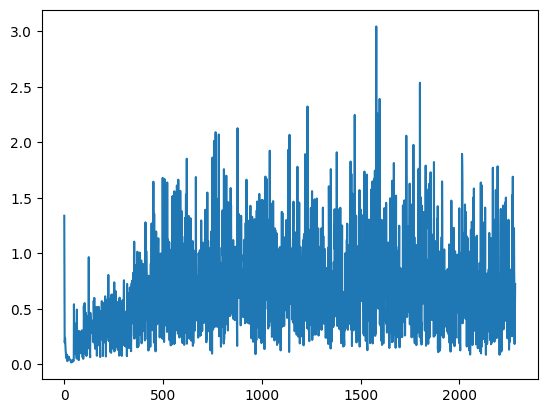

  2%|▏         | 150/9999 [16:16<19:17:25,  7.05s/it]

Reward on a test environnement at episode 150: 4.333400999103333


  2%|▏         | 199/9999 [21:03<17:58:48,  6.60s/it]

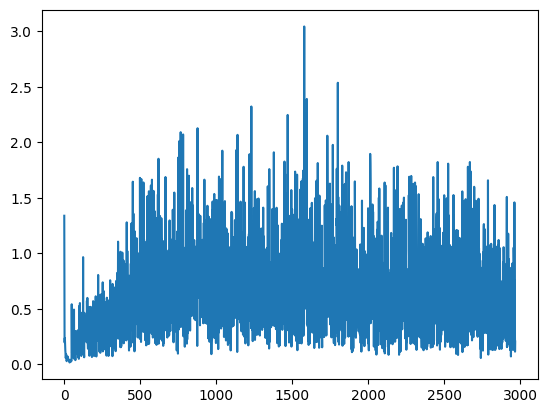

  2%|▏         | 200/9999 [21:23<29:11:49, 10.73s/it]

Reward on a test environnement at episode 200: 3.74746066730368


  2%|▏         | 231/9999 [25:21<17:51:57,  6.58s/it]


KeyboardInterrupt: 

In [10]:
dqn.train()

In [ ]:
env = 